In [13]:
# =================================================================
# 1. การนำเข้า Library และฟังก์ชันหลัก
# =================================================================
import GEOparse
import pandas as pd
import numpy as np
import os
import sys
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict

# โหลดฟังก์ชันจากไฟล์ microarray_analysis.py
from microarray_analysis import *

In [14]:
# =================================================================
# 2. การโหลดและเตรียมข้อมูล (GSE66360)
# =================================================================
filepath = r"C:\Users\user\Documents\work\medfund\test\AIBI_Analytic_tools\data\raw\GSE66360_family.soft.gz"
gse = GEOparse.get_GEO(filepath=filepath)

control_ids = gse.phenotype_data[gse.phenotype_data['title'].str.contains('Control')]['geo_accession'].to_list()
treated_ids = gse.phenotype_data[~gse.phenotype_data['title'].str.contains('Control')]['geo_accession'].to_list()

all_samples_map = {i: 'control' for i in control_ids} | {i: 'treated' for i in treated_ids}
gsm_names = list(gse.gsms.keys())
exprsdata = gse.pivot_samples('VALUE')[gsm_names].T.dropna(axis=1)

03-Feb-2026 03:46:04 INFO GEOparse - Parsing C:\Users\user\Documents\work\medfund\test\AIBI_Analytic_tools\data\raw\GSE66360_family.soft.gz: 
03-Feb-2026 03:46:04 DEBUG GEOparse - DATABASE: GeoMiame
03-Feb-2026 03:46:04 DEBUG GEOparse - SERIES: GSE66360
03-Feb-2026 03:46:04 DEBUG GEOparse - PLATFORM: GPL570
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\GEOparse\GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
03-Feb-2026 03:46:06 DEBUG GEOparse - SAMPLE: GSM1620819
03-Feb-2026 03:46:06 DEBUG GEOparse - SAMPLE: GSM1620820
03-Feb-2026 03:46:06 DEBUG GEOparse - SAMPLE: GSM1620821
03-Feb-2026 03:46:06 DEBUG GEOparse - SAMPLE: GSM1620822
03-Feb-2026 03:46:06 DEBUG GEOparse - SAMPLE: GSM1620823
03-Feb-2026 03:46:06 DEBUG GEOparse - SAMPLE: GSM1620824
03-Feb-2026 03:46:07 DEBUG GEOparse - SAMPLE: GSM1620825
03-Feb-2026 03:46:07 DEBUG GEOpars

In [15]:
# Normalization & Mapping ยีน
rank_mean = exprsdata.stack().groupby(exprsdata.rank(method='first').stack().astype(int)).mean()
exprsdata_norm = exprsdata.rank(method='min').stack().astype(int).map(rank_mean).unstack()

In [16]:
# Mapping Probe ID เป็น Gene Symbol
probe_mapping = {}
with open(r'C:\Users\user\Documents\work\medfund\test\AIBI_Analytic_tools\data\processed\probe2gene.txt') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 3: probe_mapping[parts[1]] = parts[2]

exprsdata_norm.columns = exprsdata_norm.columns.map(probe_mapping)
data_final = exprsdata_norm.loc[:, exprsdata_norm.columns.notnull()].groupby(level=0, axis=1).mean()
y_final = np.where(pd.Series(all_samples_map) == 'treated', 1, 0)

C:\Users\user\AppData\Local\Temp\ipykernel_26952\2920616260.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data_final = exprsdata_norm.loc[:, exprsdata_norm.columns.notnull()].groupby(level=0, axis=1).mean()


In [17]:
# =================================================================
# 3. LASSO Feature Selection (การคัดเลือกรายชื่อยีน)
# =================================================================
print("\n--- กำลังคัดเลือกยีนด้วย LASSO ---")
target_genes = ['LILRA1', 'CCL20', 'IL1R2', 'TYROBP', 'CXCL16', 'NFKBIA'] #

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_final)
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=50000).fit(X_scaled, y_final)
lasso = Lasso(alpha=lasso_cv.alpha_)
lasso.fit(X_scaled, y_final)

# รายชื่อยีนทั้งหมดที่ LASSO เลือกมา
selected_features_new = data_final.columns[lasso.coef_ != 0].tolist()
X_final_new = data_final[selected_features_new]
y_final_new = y_final

print(f"\n[รายชื่อยีนทั้งหมดที่ถูกเลือก ({len(selected_features_new)} ยีน)]:")
print(selected_features_new)

# เช็คว่ายีนเป้าหมายของคุณรอดมาได้กี่ตัว
found_rescued = [g for g in target_genes if g in selected_features_new]
print(f"\n[ยีนเป้าหมายที่รอดการคัดเลือก]: {found_rescued}")


--- กำลังคัดเลือกยีนด้วย LASSO ---

[รายชื่อยีนทั้งหมดที่ถูกเลือก (88 ยีน)]:
['AHNAK', 'ALAS1', 'ARHGEF4', 'ARL6', 'ATXN8OS', 'B3GNT9', 'BTN2A1', 'C12orf65', 'CASC10', 'CASS4', 'CATSPER3', 'CBLN3', 'CCL2', 'CDC42BPB', 'CEP104', 'CES4A', 'COQ9', 'DCAF4', 'DHX30', 'DIAPH3', 'EIF4EBP1', 'FAM132B', 'FCHO1', 'FMO5', 'FUT8', 'GALK2', 'GGH', 'HEXDC', 'HRAS', 'IGSF10', 'IL10RA', 'ITIH3', 'KCNH1', 'KIAA1524', 'KIDINS220', 'KIF18B', 'KRT86', 'LINC00615', 'LINC00669', 'LINC01010', 'LOC100507468', 'LOC143188', 'LOC645739', 'LRRCC1', 'LSR', 'MEOX1', 'METTL7B', 'MIIP', 'MIR663AHG', 'MOB3C', 'MOXD1', 'NID2', 'NPRL2', 'NR1D1', 'OMD', 'PHF14', 'PLD3', 'PLK4', 'PLSCR3', 'POU5F1B', 'PTCH2', 'RAI2', 'RCAN2', 'RDH16', 'RPRM', 'RPS14', 'RTCB', 'RUFY1', 'SDF2', 'SENCR', 'SFRP5', 'SH2D4A', 'SH3GL1', 'SLC17A2', 'SLC35E2', 'SPATS2L', 'TET3', 'TMCO3', 'TMED2', 'TTC30B', 'UROC1', 'VAC14', 'WBSCR22', 'WDR27', 'YLPM1', 'ZNF235', 'ZNF581', 'ZNF689']

[ยีนเป้าหมายที่รอดการคัดเลือก]: []


In [18]:
# =================================================================
# 4. Optuna: จูนทุกโมเดล (LR, RF, SVC) พร้อมกัน
# =================================================================
def objective(trial):
    # Search Space
    lr_c = trial.suggest_float('lr_c', 1e-3, 10, log=True)
    rf_n = trial.suggest_int('rf_n_estimators', 100, 500)
    rf_depth = trial.suggest_int('rf_max_depth', 3, 20)
    svc_c = trial.suggest_float('svc_c', 1e-3, 10, log=True)

    c1 = LogisticRegression(C=lr_c, random_state=42)
    c2 = RandomForestClassifier(n_estimators=rf_n, max_depth=rf_depth, random_state=42)
    c3 = SVC(C=svc_c, probability=True, random_state=42)

    eclf = VotingClassifier(estimators=[('lr', c1), ('rf', c2), ('svc', c3)], voting='soft')
    return cross_val_score(eclf, X_final_new, y_final_new, cv=5, n_jobs=-1).mean()

print("\n--- เริ่มการจูนทุกโมเดลใน Ensemble ด้วย Optuna ---")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params

[I 2026-02-03 03:47:29,270] A new study created in memory with name: no-name-5a7db35b-658b-40ab-acb7-3df5074cad6d



--- เริ่มการจูนทุกโมเดลใน Ensemble ด้วย Optuna ---


[I 2026-02-03 03:47:32,721] Trial 0 finished with value: 1.0 and parameters: {'lr_c': 1.902402775519349, 'rf_n_estimators': 493, 'rf_max_depth': 17, 'svc_c': 0.0024072990987348587}. Best is trial 0 with value: 1.0.
[I 2026-02-03 03:47:34,841] Trial 1 finished with value: 1.0 and parameters: {'lr_c': 1.4213569893137963, 'rf_n_estimators': 331, 'rf_max_depth': 15, 'svc_c': 9.496103402116757}. Best is trial 0 with value: 1.0.
[I 2026-02-03 03:47:36,906] Trial 2 finished with value: 0.9794736842105264 and parameters: {'lr_c': 0.02260640382830156, 'rf_n_estimators': 383, 'rf_max_depth': 18, 'svc_c': 0.004802361906463121}. Best is trial 0 with value: 1.0.
[I 2026-02-03 03:47:37,182] Trial 3 finished with value: 0.9694736842105263 and parameters: {'lr_c': 0.001181727927470598, 'rf_n_estimators': 178, 'rf_max_depth': 4, 'svc_c': 0.038266964892206184}. Best is trial 0 with value: 1.0.
[I 2026-02-03 03:47:37,955] Trial 4 finished with value: 1.0 and parameters: {'lr_c': 0.9120641997930937, 'rf_n

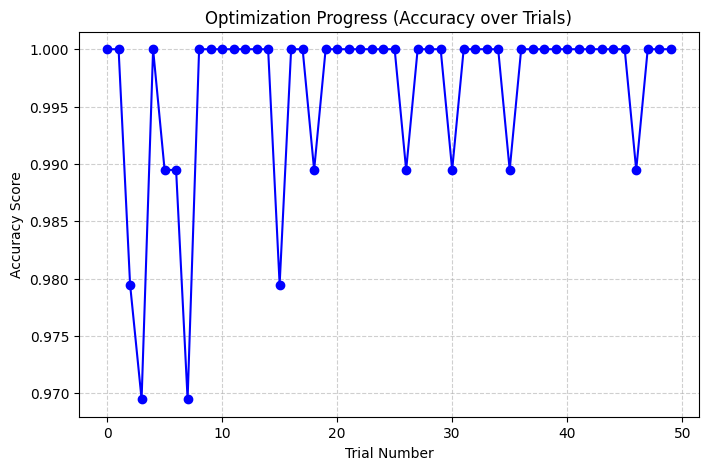

In [19]:
# =================================================================
# 5. การแสดงกราฟ Visualization และสรุปผลโมเดลสุดท้าย
# =================================================================
# แสดงกราฟประวัติการจูน (Optimization Progress)
plt.figure(figsize=(8, 5))
plt.plot([t.value for t in study.trials if t.value is not None], marker='o', linestyle='-', color='b')
plt.title('Optimization Progress (Accuracy over Trials)')
plt.xlabel('Trial Number')
plt.ylabel('Accuracy Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [20]:
# สร้างโมเดลสุดท้ายด้วยพารามิเตอร์ที่ดีที่สุด
final_rf = RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], 
                                   max_depth=best_params['rf_max_depth'], random_state=42)
final_lr = LogisticRegression(C=best_params['lr_c'], random_state=42)
final_svc = SVC(C=best_params['svc_c'], probability=True, random_state=42)

eclf_final = VotingClassifier(estimators=[('lr', final_lr), ('rf', final_rf), ('svc', final_svc)], voting='soft')
y_pred = cross_val_predict(eclf_final, X_final_new, y_final_new, cv=5)

print("\n--- Final Classification Report ---")
print(classification_report(y_final_new, y_pred))

# แสดงอันดับความสำคัญของยีน
final_rf.fit(X_final_new, y_final_new)
importances = pd.Series(final_rf.feature_importances_, index=selected_features_new)
print("\n--- Top 10 Most Important Genes (from Tuned Model) ---")
print(importances.sort_values(ascending=False).head(10))

# ตรวจสอบ Feature Importance เฉพาะยีนเป้าหมาย
print("\nFeature Importance of Target Genes:")
for g in found_rescued:
    if g in importances:
        print(f"{g}: {importances.loc[g]:.5f}")


--- Final Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        49

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99


--- Top 10 Most Important Genes (from Tuned Model) ---
IL10RA    0.091674
AHNAK     0.064440
B3GNT9    0.057376
ZNF581    0.047826
ZNF689    0.043552
HEXDC     0.040806
PLSCR3    0.039762
DIAPH3    0.030281
MOXD1     0.029223
ITIH3     0.028145
dtype: float64

Feature Importance of Target Genes:
